<a href="https://colab.research.google.com/github/GauravPatel89/EVA-Track3-Assignments/blob/master/Session6/Assignment6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate,Add

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

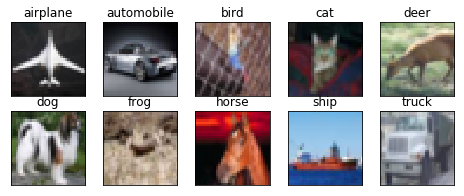

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 128)  73856       conv2d_2[0][0]                   
________________________________________________________________________________________

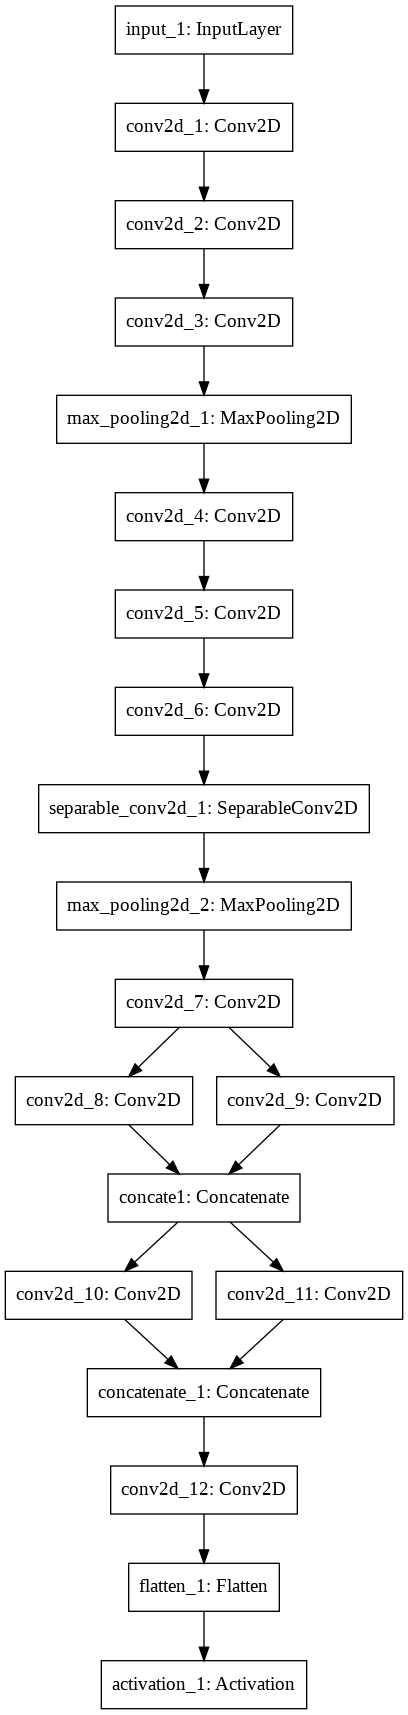

In [0]:

# first input model
inputLayer = Input(shape=(32,32,3)) #32

hidden1_conv = Conv2D(32, kernel_size=3, activation='relu',padding = 'same')(inputLayer)
hidden2_conv = Conv2D(64, kernel_size=3, activation='relu',padding = 'same')(hidden1_conv)
hidden3_conv = Conv2D(128, kernel_size=3, activation='relu',padding = 'same')(hidden2_conv)

hidden4_pool = MaxPooling2D(pool_size=(2, 2))(hidden3_conv)  #16
hidden5_conv = Conv2D(32, kernel_size=1, activation='relu',padding = 'same')(hidden4_pool)

# spatially separable
hidden6_conv = Conv2D(32,  kernel_size = (3,1), activation='relu',padding = 'same')(hidden5_conv) # 3x1 conv
hidden7_conv = Conv2D(64, kernel_size = (1,3), activation='relu',padding = 'same')(hidden6_conv) # 1x3 conv

# depthwise 
hidden8_conv = SeparableConv2D(128, kernel_size = 3, activation='relu', padding='same')(hidden7_conv)

hidden9_pool = MaxPooling2D(pool_size=(2, 2))(hidden8_conv)  #8
hidden10_conv = Conv2D(32, kernel_size=1, activation='relu', padding = 'same')(hidden9_pool)

# group conv (3x3 and 5x5)
hidden11_1_conv = Conv2D(64, kernel_size=3, activation='relu', padding = 'same')(hidden10_conv)
hidden11_2_conv = Conv2D(64, kernel_size=5, activation='relu', padding = 'same')(hidden10_conv)

hidden12_concat = concatenate([hidden11_1_conv, hidden11_2_conv],name='concate1') # 8x16

# group conv (3x3 dilation 1 and dilation 2)
hidden13_1_conv = Conv2D(128, kernel_size=3, dilation_rate=1, activation='relu', padding = 'same')(hidden12_concat)
hidden13_2_conv = Conv2D(128, kernel_size=3, dilation_rate=2, activation='relu', padding = 'same')(hidden12_concat)

hidden14_concat = concatenate([hidden13_1_conv, hidden13_2_conv]) #8x32

hidden15_conv = Conv2D(10, kernel_size=(8,8), activation='relu')(hidden14_concat)
hidden16_flat = Flatten()(hidden15_conv)
outputLayer = Activation('softmax')(hidden16_flat)


model = Model(inputs=inputLayer, outputs=outputLayer)
# summarize layers
print(model.summary())
# plot graph
plot_model(model)




In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, 
                             horizontal_flip=False)

datagen.fit(train_features)

BS=256
train_iterator = datagen.flow(train_features, train_labels, batch_size = BS)


datagenTest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, 
                             horizontal_flip=False)

datagenTest.fit(test_features)


#test_iterator = datagenTest.flow(test_features, test_labels, batch_size=len(test_features))
test_iterator = datagenTest.flow(test_features, test_labels, batch_size = BS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





195/195 [==============================] - 35s 177ms/step - loss: 2.2158 - acc: 0.1885 - val_loss: 2.1279 - val_acc: 0.2210
Epoch 2/50
195/195 [==============================] - 30s 153ms/step - loss: 2.0249 - acc: 0.2711 - val_loss: 1.9364 - val_acc: 0.2982
Epoch 3/50
195/195 [==============================] - 30s 152ms/step - loss: 1.8956 - acc: 0.3162 - val_loss: 1.8972 - val_acc: 0.3065
Epoch 4/50
195/195 [==============================] - 30s 151ms/step - loss: 1.8509 - acc: 0.3332 - val_loss: 1.8486 - val_acc: 0.3354
Epoch 5/50
195/195 [==============================] - 30s 151ms/step - loss: 1.8078 - acc: 0.3450 - val_loss: 1.8231 - val_acc: 0.3494
Epoch 6/50
195/195 [==============================] - 30s 151ms/step - loss: 1.7843 - acc: 0.3530 - val_loss: 1.8198 - val_acc: 0.3479
Epoch 7/50
195/195 [==============================] - 30s 152ms/step - loss: 1.6815 - ac

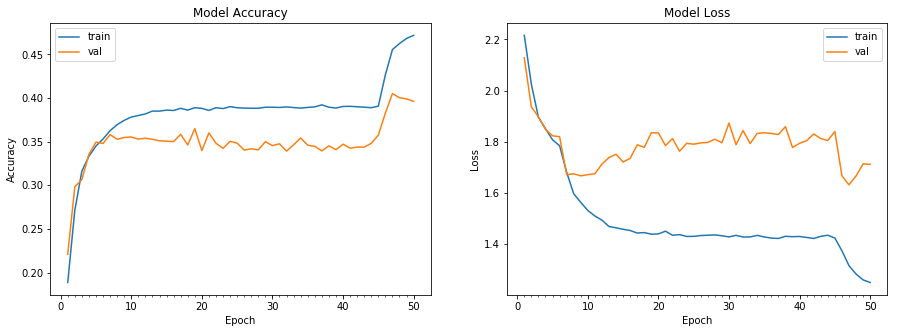

In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_iterator, steps_per_epoch = (len(train_features)//BS), epochs = 50, 
                                 validation_data = test_iterator, validation_steps = (len(test_features)//BS), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)


In [0]:
# Since we have trained our model on Normalized input images, we must normalize the test data before predicting test accuracy
test_iterator = datagenTest.flow(test_features, test_labels, batch_size = test_features.shape[0])

# Obtain a batch a normalized test data
batchX, batchY = test_iterator.next()

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(batchX, batchY, model))

Accuracy on test data is: 39.74
